# Generate dataset

In this notebook dataset consisting of 1000000 patients (both indicators and tumor size charts) are generated using the original QSP model.

When for given patient indicators QSP returns an error, another indicators are generated.

The result is saved in `./final/dataset.npz`

In addition a metadata file (`./final/dataset_metadata.json`) is saved containing total times of generating patients indicators, tumor size time profiles and saving the result file.

Note: this notebook requires `R` in which the original QSP model is written. This model also requires package `deSolve` to be installed in `R`.

In [1]:
from pathlib import Path

# number of patients in dataset
DATASET_SIZE = 1_000_000

MODEL_PATH = Path("../qspRPlusC/simulateQSP.R").resolve()
SAVE_PATH = Path("../final")

assert MODEL_PATH.exists(), f"Model file {MODEL_PATH} does not exist"

In [2]:
# generating patient indicators
import numpy as np
import time

DISTRIBUTION_PARAMETERS = np.array(
    [
        [0.05, 0.5],
        [-2.436, 0.62335],
        [-2.58098, 0.69689],
        [0.2, 0.4],
        [0.005, 0.01],
        [0.01155, 0.0231],
        [0.15, 0.30],
        [150, 300],
        [0.75, 1.5],
        [1e-5, 0.01],
    ]
)
PARAMETER_NAMES = [
    "Fraction of leukocytes in tumour",
    "Fraction of cytotoxic T-cells in tumour",
    "Fraction of antigen presenting cells in tumour",
    "tumour growth rate",
    "Stroma growth rate",
    "tumour death rate",
    "tumour kill rate by cytotoxic T-cells",
    "The rate of cytotoxic T-cell exhaustion by PD1",
    "T-cell proliferation in lymph node",
    "Initial tumour volume",
]
LOGNORMAL_PARAMETERS = (1, 2)
np.random.seed(seed=42)


def generate_patient_indicators(size):
    generation_start_time = time.time()

    patient_indicators = np.zeros((size, 11))
    patient_indicators[:, 0] = np.ones(
        size
    )  # first indicator tells if treatment was applied

    for i, distribution_parameters in enumerate(DISTRIBUTION_PARAMETERS):
        if i in LOGNORMAL_PARAMETERS:
            patient_indicators[:, i + 1] = np.random.lognormal(
                mean=distribution_parameters[0],
                sigma=distribution_parameters[1],
                size=size,
            )
        else:
            patient_indicators[:, i + 1] = np.random.uniform(
                low=distribution_parameters[0],
                high=distribution_parameters[1],
                size=size,
            )

    generation_time_s = time.time() - generation_start_time

    return patient_indicators, generation_time_s


patient_indicators, patient_indicators_generation_time_s = generate_patient_indicators(
    DATASET_SIZE
)

print(
    f"Generated {DATASET_SIZE} sets of patients indicators in {patient_indicators_generation_time_s} seconds"
)

Generated 1000000 sets of patients indicators in 0.19119858741760254 seconds


In [3]:
# Displaying sample of indicators
from IPython.display import HTML, display

sample_size = min(DATASET_SIZE, 8)
html = f"<table><tr><th>Indicator</th><th>Distribution</th>{''.join(f'<th>p{i}</th>' for i in range(sample_size))}</tr>"
for i, indicator_name in enumerate(PARAMETER_NAMES):
    html += f"<tr><td>{indicator_name}</td><td>"
    if i in LOGNORMAL_PARAMETERS:
        html += f"lognormal(mean={DISTRIBUTION_PARAMETERS[i][0]}, sigma={DISTRIBUTION_PARAMETERS[i][1]})"
    else:
        html += (
            f"uniform({DISTRIBUTION_PARAMETERS[i][0]}, {DISTRIBUTION_PARAMETERS[i][1]})"
        )
    html += "</td>"
    html += "".join(
        f"<td>{patient_indicators[j,i+1]:.3f}</td>" for j in range(sample_size)
    )
    html += "</tr>"
html += "</table>"
display(HTML(html))

Indicator,Distribution,p0,p1,p2,p3,p4,p5,p6,p7
Fraction of leukocytes in tumour,"uniform(0.05, 0.5)",0.219,0.478,0.379,0.319,0.120,0.120,0.076,0.440
Fraction of cytotoxic T-cells in tumour,"lognormal(mean=-2.436, sigma=0.62335)",0.030,0.186,0.088,0.082,0.092,0.159,0.062,0.117
Fraction of antigen presenting cells in tumour,"lognormal(mean=-2.58098, sigma=0.69689)",0.110,0.196,0.045,0.045,0.198,0.098,0.079,0.263
tumour growth rate,"uniform(0.2, 0.4)",0.204,0.227,0.353,0.350,0.394,0.204,0.353,0.343
Stroma growth rate,"uniform(0.005, 0.01)",0.005,0.010,0.009,0.009,0.007,0.008,0.006,0.009
tumour death rate,"uniform(0.01155, 0.0231)",0.012,0.014,0.017,0.018,0.023,0.021,0.021,0.017
tumour kill rate by cytotoxic T-cells,"uniform(0.15, 0.3)",0.206,0.201,0.191,0.265,0.171,0.299,0.232,0.201
The rate of cytotoxic T-cell exhaustion by PD1,"uniform(150.0, 300.0)",237.070,225.328,163.055,243.266,204.784,200.891,251.118,297.879
T-cell proliferation in lymph node,"uniform(0.75, 1.5)",1.187,1.312,1.025,1.347,1.274,1.481,0.872,0.776
Initial tumour volume,"uniform(1e-05, 0.01)",0.002,0.010,0.003,0.003,0.006,0.000,0.010,0.009


In [4]:
# importing model
import os
from contextlib import redirect_stderr, redirect_stdout
from io import StringIO

from multiprocess import Process, Queue, cpu_count

from rpy2 import robjects
from rpy2.rinterface_lib.embedded import RRuntimeError
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage


END_VALUE = "end"


def load_r_model():
    """Loads R model from file and returns it as a python object."""
    model_path = MODEL_PATH
    cur_dir = Path.cwd()
    try:
        os.chdir(model_path.parent)
        with model_path.open("r") as f_p:
            model = SignatureTranslatedAnonymousPackage(f_p.read(), "model")
    finally:
        os.chdir(cur_dir)
    return model


def calc_model_point(coord, model):
    """
    Calculate tumor volume trajectory for given patient indicators.

    :param coord: patient start parameters
    :param model: R model
    :return: trajectory of tumor volume
    """
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            res = model.simulateQSP(robjects.FloatVector(coord))[0]
    except RRuntimeError as r_exception:
        raise ValueError(f"Error in simulation {r_exception.args[0]}") from r_exception
    stream.seek(0)
    err_stream.seek(0)
    if stream.read() or err_stream.read():
        # if simulation is unstable model writes this information to standard output.
        # So if there is any text on standard output we assume that simulation is unstable.
        raise ValueError("Unstable simulation")
    index = list(res.names).index("Tumor_volume")
    return list(res[index])


def calc_model_point_mp(in_queue: Queue, out_queue: Queue):
    """
    This is worker function for multiprocessing.
    It loads R model and then calculates tumor volume trajectory for patient indicators
    that are passed to it via in_queue. Results are passed to out_queue.

    :param in_queue: queue to collect patient indicators
    :param out_queue: queue where results are passed
    """
    stream = StringIO()
    err_stream = StringIO()
    try:
        with redirect_stdout(stream), redirect_stderr(err_stream):
            model = load_r_model()
    except (RRuntimeError, FileNotFoundError) as e:
        out_queue.put((None, e))
        raise

    while True:
        input_data = in_queue.get()
        if input_data == END_VALUE:
            return

        i, coord = input_data
        try:
            res = calc_model_point(coord, model)
            out_queue.put((i, res))
        except ValueError as e:
            res = [coord[10], *([100.0 * coord[10]] * 199)]
            out_queue.put((i, res))


def collect_result(
    out_queue: Queue, tumor_time_profiles: np.ndarray, progress_bar=None
):
    """
    Collects results from out_queue and terminates processes.

    :param out_queue: queue where results are passed
    :param tumor_time_profiles: array to store results
    :param progress_bar: progress bar to update
    :return: list of results
    """

    # we assume that if we cannot collect result from out_queue in 60 seconds
    # then something is wrong and we terminate processes
    ind, data_row = out_queue.get(timeout=60)
    if ind is None:
        raise RuntimeError("Loading model fails") from data_row
    tumor_time_profiles[ind, :] = data_row
    if progress_bar is not None and data_row[0] * 100 != data_row[1]:
        progress_bar.update(1)


def model_predict_with_progress(input_data, progress_bar) -> np.array:
    in_queue = Queue()
    out_queue = Queue()
    process_list = []
    process_num = cpu_count()

    for _ in range(process_num):
        proc = Process(target=calc_model_point_mp, args=(in_queue, out_queue))
        proc.start()
        process_list.append(proc)

    res_time_profiles = np.empty((input_data.shape[0], 200))
    calculated = 0

    try:
        for i, coord in enumerate(input_data):
            in_queue.put((i, coord))

            if i > 10 * process_num:
                collect_result(out_queue, res_time_profiles, progress_bar)
                calculated += 1

        while calculated < input_data.shape[0]:
            collect_result(out_queue, res_time_profiles, progress_bar)
            calculated += 1
        return res_time_profiles
    finally:
        for _ in range(process_num):
            in_queue.put(END_VALUE)

        for i in range(process_num):
            process_list[i].join()

In [5]:
# Testing model (generating time profiles for sample of patients)
from tqdm.notebook import tqdm

pbar = tqdm(total=sample_size)
sample_time_profiles = model_predict_with_progress(
    patient_indicators[:sample_size, :], pbar
)
pbar.close()

  0%|          | 0/8 [00:00<?, ?it/s]

make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.


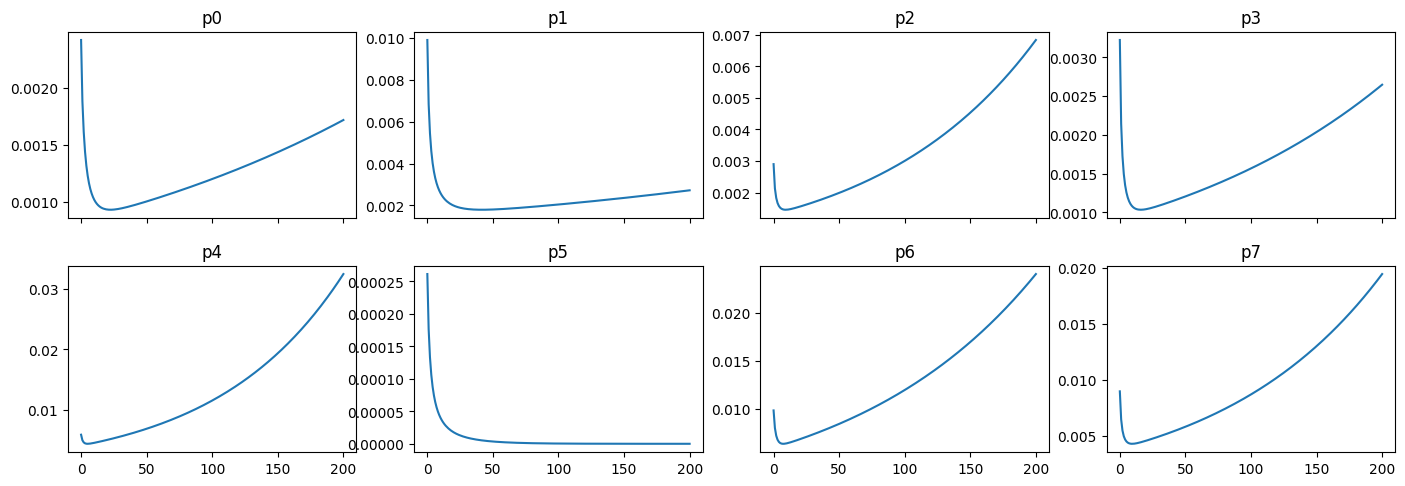

In [6]:
# displaying sample time profiles
%matplotlib inline
import matplotlib.pyplot as plt

x_axis = np.linspace(0, 200, sample_time_profiles.shape[1])

rows, cols = (sample_size + 3) // 4, 4
figure, axs = plt.subplots(rows, cols, sharex=True)
figure.set_size_inches(cols * 3.5, rows * 3)
figure.tight_layout(h_pad=2.4, rect=(0, 0, 1, 1.0 - 0.4 / rows))

for row in range(rows):
    for col in range(cols):
        i = row * cols + col
        if i < sample_size:
            axs[row, col].set_title(f"p{i}")
            axs[row, col].plot(x_axis, sample_time_profiles[i, :])

In [7]:
from tqdm.notebook import tqdm


with tqdm(total=DATASET_SIZE) as pbar:
    time_profiles_generate_start_time = time.time()
    time_profiles = model_predict_with_progress(patient_indicators, pbar)
    time_profiles_generation_time_s = time.time() - time_profiles_generate_start_time

    missing_indices = time_profiles[:, 0] * 100.0 == time_profiles[:, 1]
    missing_count = np.count_nonzero(missing_indices)

    while missing_count > 0:
        (
            patient_indicators[missing_indices == True, :],
            generation_time_s,
        ) = generate_patient_indicators(missing_count)
        patient_indicators_generation_time_s += generation_time_s

        time_profiles_generate_start_time = time.time()
        time_profiles[missing_indices == True, :] = model_predict_with_progress(
            patient_indicators[missing_indices == True, :], pbar
        )
        time_profiles_generation_time_s += (
            time.time() - time_profiles_generate_start_time
        )

        # on failed generation a profile [x, 100x, 100x, ..., 100x] is generated
        # also valid for not filled time profiles (zeros)
        missing_indices = time_profiles[:, 0] * 100.0 == time_profiles[:, 1]
        missing_count = np.count_nonzero(missing_indices)

  0%|          | 0/1000000 [00:00<?, ?it/s]

make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobienia w 'all'.
make: Nie ma nic do zrobi

In [8]:
from pathlib import Path

saving_start_time = time.time()
np.savez_compressed(
    SAVE_PATH / "dataset.npz",
    inputs=np.array(patient_indicators, dtype=np.float32),
    outputs=np.array(time_profiles, dtype=np.float32),
    params="default",
)
saving_time_s = time.time() - saving_start_time
print(f"Saved indicators and time profiles in {saving_time_s:.3f}s")

Saved indicators and time profiles in 29.724s


In [9]:
import json
import cpuinfo

metadata = {
    "patient_indicators_generate_time_s": patient_indicators_generation_time_s,
    "time_profiles_generation_time_s": time_profiles_generation_time_s,
    "saving_time_s": saving_time_s,
    "dataset_size": DATASET_SIZE,
    "cpu_info": {
        k: v
        for k, v in cpuinfo.get_cpu_info().items()
        if k in ("arch", "bits", "brand_raw", "count", "l2_cache_size")
    },
}
with (SAVE_PATH / "dataset_metadata.json").open("w") as opened_file:
    metadata_string = json.dumps(metadata, sort_keys=True, indent=4)
    opened_file.write(metadata_string)
    print(metadata_string)

{
    "cpu_info": {
        "arch": "X86_64",
        "bits": 64,
        "brand_raw": "Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz",
        "count": 12,
        "l2_cache_size": 65536
    },
    "dataset_size": 1000000,
    "patient_indicators_generate_time_s": 0.1921405792236328,
    "saving_time_s": 29.723872900009155,
    "time_profiles_generation_time_s": 9030.063203811646
}
